## Création d'un environnement Conda avec Python 3.11 et installation des dépendances

Lancez les commandes suivantes dans le terminal :

```bash
# Créer un environnement conda avec Python 3.11
conda create --name mon_env python=3.11

# Activer l'environnement
conda activate mon_env

# Installer les dépendances à partir du fichier requirements.txt
pip install -r requirements.txt

# Vérifier les installations
pip list


# Partie 1: Cleaning du dataset

In [15]:
#import des librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
def read_data_dict(filename=None) :
    # Liste des variables pertinentes (créée à partir d'un fichier 'maison')   
    with open(filename) as f:
        lignes = f.readlines()
    data_dict = {}
    i=0
    while i < len(lignes):
        if lignes[i] == '\n': #ligne vide, on passe à la suivante
            i += 1
            continue
        elif lignes[i].endswith(':\n'): #on détecte un label (une catégorie de variables)
            my_categ = lignes[i].rstrip(':\n')
            #print("Label : {}".format(my_categ))
            my_var = []
            #on récupère les variables associées à ce label
            j = i+1
            #on recherche l'index de l'éventuel prochain label
            while j < len(lignes) and (not lignes[j].endswith(':\n')): 
                j += 1
            #on va parcourir les variables déclarées à la suite de ce label, qu'on rangera dans une liste
            k = i+1 
            while k < j:
                if not lignes[k].isspace():
                    lignes[k] = lignes[k].rstrip('\n')
                    my_var.append(lignes[k])                
                k += 1
            data_dict[my_categ] = my_var
            i = j
    return data_dict

In [17]:
NOTEBOOK_FILES_PATH = "./notebook-files/"

## Structure du dataset

In [19]:
# Chargement du dataset
DATASET_FILENAME = 'fr.openfoodfacts.org.products.csv'
df = pd.read_csv(DATASET_FILENAME, sep='\t')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'fr.openfoodfacts.org.products.csv'

In [5]:
# set low_memory= False ou 
# Conversion des colonnes en chaîne de caractères (si message d'erreur sur les types)
cols_to_convert = [0, 24, 25, 26, 28, 44, 49, 61]
df.iloc[:, cols_to_convert] = df.iloc[:, cols_to_convert].astype(str)

In [6]:
# Taille du dataset
print("Le dataset contient {} lignes et {} colonnes.".format(df.shape[0], df.shape[1]))

Le dataset contient 1403863 lignes et 181 colonnes.


## Suppression des colonnes vides

In [7]:
# détection et suppression des colonnes vides
for col in df.columns:
    my_col = df[col]
    if my_col.count()==0:
        print('{} est vide'.format(col))
        df.drop(labels=col, axis=1, inplace=True)

cities est vide
allergens_fr est vide
no_nutriments est vide
ingredients_from_palm_oil est vide
ingredients_that_may_be_from_palm_oil est vide
caproic-acid_100g est vide
lignoceric-acid_100g est vide
melissic-acid_100g est vide
elaidic-acid_100g est vide
gondoic-acid_100g est vide
mead-acid_100g est vide
erucic-acid_100g est vide
nervonic-acid_100g est vide
water-hardness_100g est vide


In [8]:
print("Le dataset contient {} lignes et {} colonnes.".format(df.shape[0], df.shape[1]))

Le dataset contient 1403863 lignes et 167 colonnes.


## Détection et traitement des doublons

In [9]:
# convertit les codes en str
df['code'] = df['code'].astype(str)
# on crée un DF sous-ensemble contenant uniquement les éléments en doublons
codes = df['code']
df_dupli = df[codes.isin(codes[codes.duplicated()])].sort_values('code')
# liste des codes doublons
codes_doublon = df_dupli['code'].unique()
print("Nombre d'éléments en doublon : {}".format(df_dupli.shape[0]))

Nombre d'éléments en doublon : 1845


In [10]:
i = 0
# en cas de doublons, on élimine les éléments les plus anciens (avec timestamp)
while i < len(codes_doublon):
    my_code_dupli = codes_doublon[i]
    my_df = df_dupli.loc[df['code'] == my_code_dupli]
    # on récupère l'index de la ligne qui a le max pour 'last_modified_t' (le plus récent)
    id_max = my_df['last_modified_t'].idxmax()
    # on l'écarte de notre DF de doublons (afin qu'il ne reste que les plus anciens dans ce tableau)
    df_dupli = df_dupli.drop(index=id_max)
    i += 1

In [11]:
#on supprime les doublons du DF de départ à partir des index identifiés dans df_dupli
df = df.drop(index=df_dupli.index)

In [12]:
#vérification a posteriori
codes = df['code']
df_dupli = df[codes.isin(codes[codes.duplicated()])].sort_values('code')
print("Nombre d'éléments en doublon : {}".format(df_dupli.shape[0]))

Nombre d'éléments en doublon : 0


## Adéquation entre le dataset et le fichier descriptif 'data-fields.txt'
Objectif : passer en revue tous les champs mentionnés dans "https://world.openfoodfacts.org/data/data-fields.txt"
en vérifiant s'ils sont présents ou non dans le dataset.<br/>
Tous les champs mentionnés MAIS NON présents dans le dataset seront listés dans le fichier "fr-data-fields-NOK.txt".<br/>
Tous les champs mentionnés ET présents dans le dataset seront listés dans le fichier "fr-data-fields-OK.txt".

In [13]:
DATAFIELDS_FILENAME = 'data-fields-SHORT.txt'
with open(NOTEBOOK_FILES_PATH+DATAFIELDS_FILENAME) as f:
    lignes = f.readlines()

# Crée une liste de champs (data fields) et cleane le fichier 'data-fields.txt'
# en supprimant les champs inexistants dans le dataset

# liste de champs réellement présent dans le dataframe
data_fields = []
# infos (liste de lignes) à écrire dans les fichiers de sortie, un fichier OK, et un NOK
field_ok = []
field_nok = []
i=0
while i < len(lignes):
    #print(lignes[i])
    # si la ligne vide ou commence par un #, on passe à la suivante
    if (lignes[i] == '\n') or (lignes[i].strip().startswith('#')):
        field_ok.append(lignes[i])
        field_nok.append(lignes[i])
        i += 1
        continue
    else:
        field = (lignes[i].split(':'))[0].strip()
        # vérifie que ce champ existe bien dans le dataframe.
        # Si oui, on conserve ce champ et on copie la ligne
        if field in df.columns:
            data_fields.append(field)
            field_ok.append(lignes[i])
        #sinon le champ en question n'existe pas dans le dataframe, on le copiera dans un autre fichier
        else:
            field_nok.append(lignes[i])
        i += 1


In [14]:
# On crée le fichier version cleanée
OK_DATAFIELDS_FILENAME = 'fr-data-fields-OK.txt'
with open(NOTEBOOK_FILES_PATH+OK_DATAFIELDS_FILENAME, 'w') as f:
    f.writelines(field_ok)
    
# On crée le fichier des champs "not OK"
NOK_DATAFIELDS_FILENAME = 'fr-data-fields-NOK.txt'
with open(NOTEBOOK_FILES_PATH+NOK_DATAFIELDS_FILENAME, 'w') as f:
    f.writelines(field_nok)

## Sélection des variables pertinentes et structuration dans un dictionnaire

In [15]:
FOODFACTS_VARIABLE_FILENAME = 'NB-data-structure.txt'
data_dict = read_data_dict(NOTEBOOK_FILES_PATH+FOODFACTS_VARIABLE_FILENAME)

## Détection de valeurs erronées

### Teneurs des macro-nutriments
Critères : <br/>
-la teneur d'un macro-nutriment dépasse 100g<br/>
OU<br/>
-la somme des teneurs des macro-nutriments dépasse 100g

In [16]:
items_to_check = data_dict['ITEMS_TO_CHECK']

In [17]:
nb_valeurs_erronees = 0

# détection et suppression des entrées dont un macro-nutriment est en dehors de l'intervalle 0 - 100g
for item in items_to_check:    
    index = df.query("`{0}` < 0 | `{0}` > 100".format(item)).index
    #on supprime les valeurs erronées à partir des index
    df.drop(index = index, axis=0, inplace=True)
    nb_valeurs_erronees += len(index)    

In [18]:
# détection et suppression des entrées dont la somme des macro-nutriments dépasse 100g
# on crée une colonne 'total_macro_nut' qui recevra la somme des teneurs des macro-nutriments
#(pour 100g d'aliment)
macro_nutriments = data_dict['MACRO NUTRIMENTS']
# colonne temporaire pour stocker la somme des teneurs des macro-nutriments
df['total_macro_nut'] = 0

for macro_n in macro_nutriments:
    #remplace les NaN par 0
    df[macro_n].fillna(0, inplace=True)
    # ajoute la teneur de ce macro n. au total
    df['total_macro_nut'] += df[macro_n]

index_to_delete = df.query('total_macro_nut < 0 | total_macro_nut > 100').index
df.drop(index = index_to_delete, axis=0, inplace=True)
nb_valeurs_erronees += len(index_to_delete)
#suppression de la colonne temporaire
df.drop(columns='total_macro_nut', inplace=True)

### Teneurs en énergie

In [19]:
index_to_delete = df.query('`energy-kj_100g` > 4000 | `energy-kcal_100g` > 1000').index
#Suppression des outliers pour les teneurs en énergie
df.drop(index = index_to_delete, axis=0, inplace=True)
nb_valeurs_erronees += len(index_to_delete)

### Autres détection de valeurs erronées (par famille de nutriments)
Critères d'erreur :<br/>
- sugars_100g > carbohydrates_100g
- saturated-fat_100g > fat_100g
- fruits-vegetables-nuts_100g + saturated-fat_100g > 100

In [20]:
index_to_delete = df.query('`sugars_100g` > `carbohydrates_100g`').index
df.drop(index = index_to_delete, axis=0, inplace=True)
nb_valeurs_erronees += len(index_to_delete)

In [21]:
index_to_delete = df.query('`saturated-fat_100g` > `fat_100g`').index
df.drop(index = index_to_delete, axis=0, inplace=True)
nb_valeurs_erronees += len(index_to_delete)

In [22]:
print("Nombre total de valeurs erronées : {}".format(nb_valeurs_erronees))

Nombre total de valeurs erronées : 49613


## <i>optionnel</i> : Créations de fichiers textes contenant les valeurs d'une sélection de colonnes
Utile pour une pré-exploration de ces champs

In [23]:
# On stocke le contenu (valeurs uniques et triées) des colonnes clés dans des fichiers txt
tag_selection = ['labels','labels_tags','labels_fr',
                 'categories', 'categories_tags', 'categories_fr',
                 'origins','origins_tags',
                 'cities_tags','stores',
                'countries','countries_tags','countries_fr',
                ]

for my_tag in tag_selection:
    filename = NOTEBOOK_FILES_PATH+"TAG-"+my_tag+".txt"
    tag_values = sorted(df[my_tag].drop_duplicates().astype('str'))
    with open(filename, 'w', encoding='utf-8') as f:
        f.write('\n'.join(tag_values) + '\n')

## Sauvegarde du dataframe 'cleané'

In [24]:
DF_NEWFILENAME = 'fr.openfoodfacts.org.products-CLEAN.csv'

df.to_csv(DF_NEWFILENAME, sep='\t', encoding='utf-8')

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


# Partie 2 : Exploration du dataset

In [141]:
#import des librairies
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, HTML
import re

In [142]:
# Largeur du notebook
display(HTML("<style>.container { width:80% !important; }</style>"))

In [143]:
FOODFACTS_VARIABLES_FILENAME = 'NB-data-structure.txt'

ns_intervalles = [-15, -2, 3, 11, 16, 40]
ns_lettres = ['A', 'B', 'C', 'D', 'E']

## Chargement du dataset
 (chargement du dict de structure des données)

In [144]:
DF_FILENAME = 'fr.openfoodfacts.org.products-CLEAN.csv'
# Chargement du dataset
df = pd.read_csv(DF_FILENAME, sep='\t')
data_dict = read_data_dict(NOTEBOOK_FILES_PATH+FOODFACTS_VARIABLES_FILENAME)

/var/folders/1f/fpt1htxn5rz9ggs624xhtxh40000gn/T/ipykernel_10470/1105275652.py:3: DtypeWarning: Columns (1,25,26,27,28,42,46,48,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DF_FILENAME, sep='\t')


### Nouvelles suppression de doublons

In [145]:
my_fields = set((data_dict['NS_BAD_ITEMS']       
       +data_dict['MACRO NUTRIMENTS']
                 +['product_name']                 
                 +['energy-kcal_100g']))
my_fields

{'carbohydrates_100g',
 'energy-kcal_100g',
 'fat_100g',
 'fiber_100g',
 'product_name',
 'proteins_100g',
 'saturated-fat_100g',
 'sodium_100g',
 'sugars_100g'}

In [146]:
# suppression de doublons à partir de la composition en nutriments et du nom du produit
df = df.drop_duplicates(subset=my_fields)

### Taux de remplissage des données

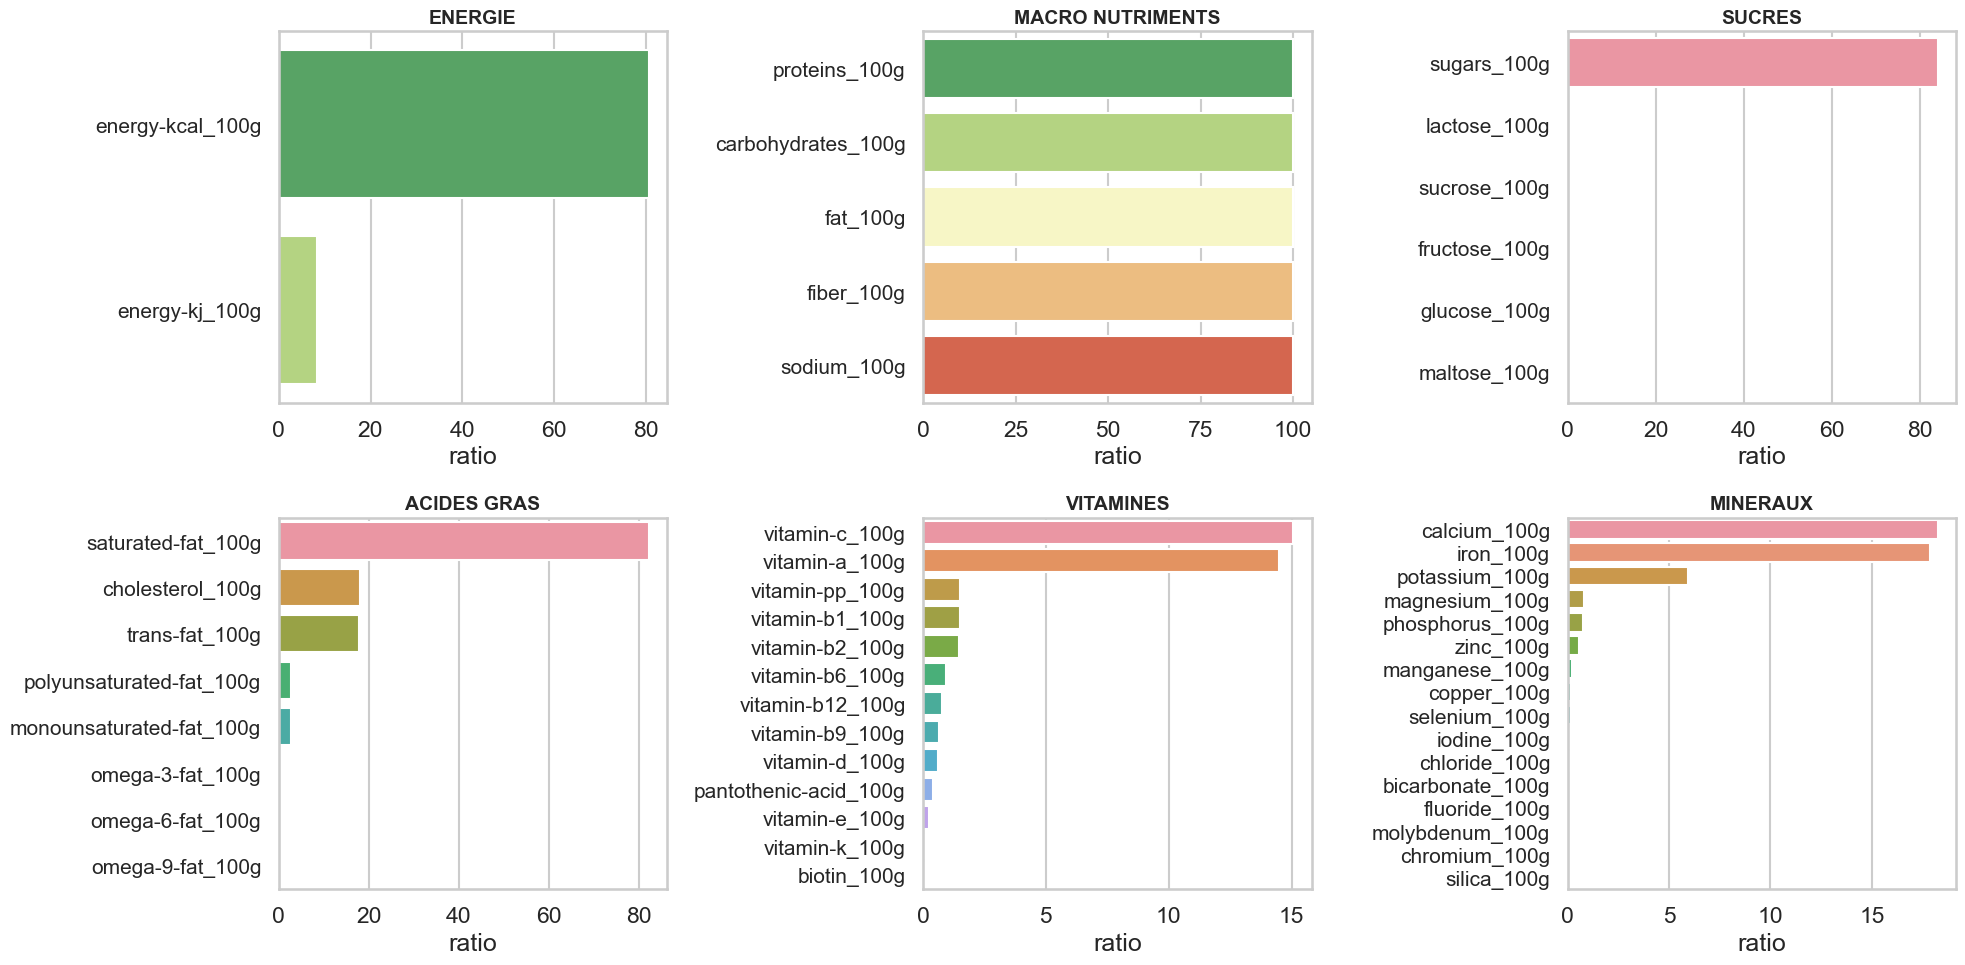

In [147]:
items_groups = ['ENERGIE', 'MACRO NUTRIMENTS', 'SUCRES', 'ACIDES GRAS', 'VITAMINES', 'MINERAUX']
df_taux_rempli = pd.DataFrame(columns=['group','variable','ratio'])

# on calcule les ratios et on les stocke dans un DF
for group in items_groups:
    for item in data_dict[group]:
        ratio = (df[item].count() / df.shape[0]) * 100
        # Créer un DataFrame à partir du dictionnaire 'md'
        md_df = pd.DataFrame([{'group': group, 'variable': item, 'ratio': ratio}])
        # Concaténer avec 'df_taux_rempli'
        df_taux_rempli = pd.concat([df_taux_rempli, md_df], ignore_index=True)

# tri décroissant        
df_taux_rempli = df_taux_rempli.sort_values('ratio', ascending=False).reset_index()        

# représentation en histogrammes par groupe
sns.set_style('whitegrid', rc={"grid.linewidth": 0.1})
fig, ax = plt.subplots(2,3, figsize=(20,10))

#repérage des axes par un seul index (une dimension)
ax = ax.flatten()

for i, group in enumerate(items_groups):   
    df_temp = df_taux_rempli[ df_taux_rempli['group'] == group ]    
    g = sns.barplot(x="ratio",
            y="variable",
            ax=ax[i],            
            orient="h",
            data=df_temp)
    g.set_ylabel('')
    g.tick_params(axis='y', which='major', labelsize=15)
    g.set_title(group, fontsize=14, fontweight='bold')

# on ajuste les dimensions des subplots dans la figure pour éviter les chevauchements
fig.tight_layout()
    

## Etude du Nutri-score - valeurs numériques et classification (A à E)
La valeur numérique est stockée dans 'nutrition-score-fr_100g'<br/>
La conversion en lettre se fait sur la base du document :<br/>
https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique

Le Nutri-score va donc de -15 à 40.<br/>
Correspondances entre valeurs numérique et classes (lettre) :<br/>
-15 à -2 : vert/A<br/>
-1 à 3 : vert clair/B<br/>
4 à 11 : jaune/C<br/>
12 à 16 : orange/D<br/>
Plus de 17 : rouge/E

In [148]:
# la variable 'nutrition-score-fr_100g' est-elle bien renseignée ?
(df['nutrition-score-fr_100g'].count() / df.shape[0])

0.42402482103169664

### Visualisation de la distribution Nutri-score avant imputation

In [149]:
# On sélectionne les colonnes à garder
ns_items = data_dict['NS_ITEMS']
ns_grade_items = data_dict['NS_GRADE']

# On crée une nouvelle colonne 'nutrition_grade_fr' dans le DataFrame d'origine
# qui sera remplie avec les données de nutrition-score-fr_100g
df['nutrition_grade_fr'] = ""

# On définit les colonnes à conserver
col_ns = ns_items + ns_grade_items

# Nouveau DataFrame issu de la réduction dimensionnelle du DataFrame d'origine
df_ns = df[col_ns].copy()  # Assurez-vous de travailler sur une copie

# Création des catégories avec pd.cut
lettre_series = pd.cut(x=df['nutrition-score-fr_100g'], labels=ns_lettres, bins=ns_intervalles, right=True)

# Utilisation de .assign() pour ajouter la colonne dans df_ns
df_ns = df_ns.assign(nutrition_grade_fr=lettre_series)

# Utilisation de .assign() pour ajouter la colonne dans df
df = df.assign(nutrition_grade_fr=lettre_series)


In [150]:
print(df_ns['nutrition-score-fr_100g'].unique())

[ nan  18.   1.  14.  -2.   4.   0.  -4.  15.  17.  21.   2.   3.  29.
   6.  22.   9.   7.   5.  24.  13.  12.  16.  26.  19.  11.  36.  -3.
  20.  27.  10.  23.  25.  -5.  -1.  28.  -8.  -6.  -9.   8.  -7.  30.
 -10. -11. -13. -12. -14.  33.  31.  34.  32.  35. -15.  40.  37.]


In [151]:
# Definit la palette propre au Nutri-score
sns.set_palette("RdYlGn_r", 5)
sns.set_style("darkgrid")
sns.set_context("notebook")


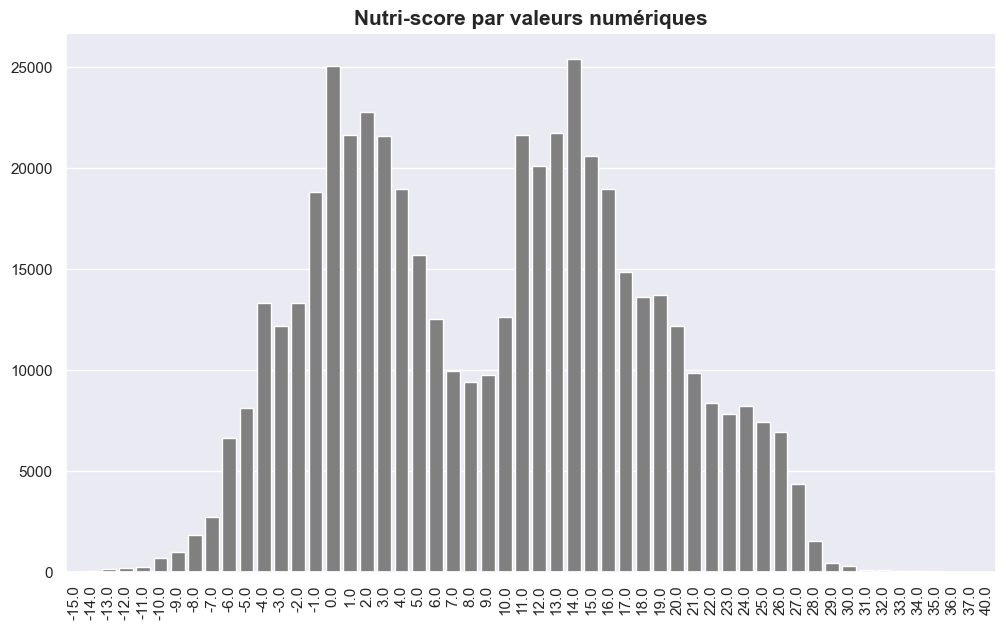

In [152]:
# distribution du Nutri-score "numérique"
plt.figure(figsize=(12,7))
h = sns.countplot(x="nutrition-score-fr_100g", data=df_ns, color='grey')
h.set_title("Nutri-score par valeurs numériques", fontweight='bold', fontsize=15)
h.set_xticklabels(h.get_xticklabels(),rotation=90)
h.set_xlabel('') ;  h.set_ylabel('')
# h.set(xlim=(-15, 35))
plt.show(h)

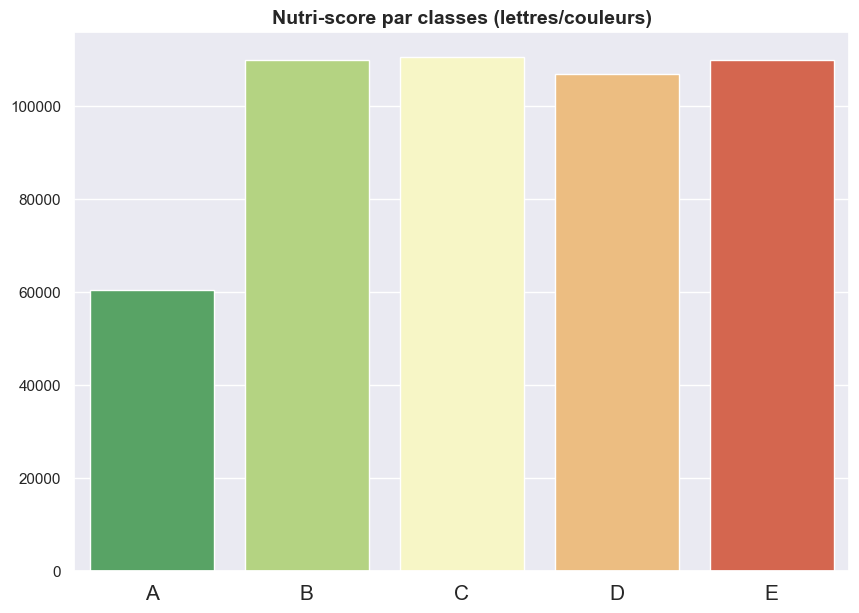

In [153]:
f = plt.figure(figsize=(10,7))
# sns.set(style="whitegrid")
g = sns.countplot(x=df_ns["nutrition_grade_fr"], data=df_ns)
g.set_ylabel('') ; g.set_xlabel('')
g.tick_params(axis='x', which='major', labelsize=15)
g.set_title('Nutri-score par classes (lettres/couleurs)', fontsize=14, fontweight='bold')
plt.show(g)

### Imputation des nutri-scores manquants par kNN

#### Imputation KNN

In [154]:
# on supprime les entrées où il y a trop de valeurs manquantes
df_ns2 = df_ns.dropna(subset=ns_items, thresh=6)

df_ns2 = df_ns2.drop("nutrition_grade_fr", axis=1)

# évaluation du taux de remplissage des données NS
for item in ns_items:
    ratio = (df_ns2[item].count() / df_ns2.shape[0])*100
    print("{} : renseigné à {} %".format(item,ratio))

fiber_100g : renseigné à 100.0 %
fruits-vegetables-nuts_100g : renseigné à 100.0 %
sugars_100g : renseigné à 100.0 %
saturated-fat_100g : renseigné à 100.0 %
sodium_100g : renseigné à 100.0 %
energy-kcal_100g : renseigné à 100.0 %


In [155]:
# sépare le dataset entre données d'entrainement et données à imputer
df_ns2_train = df_ns2.dropna(subset=['nutrition-score-fr_100g'])
df_ns2_test = df_ns2[df_ns2['nutrition-score-fr_100g'].isnull()]

In [156]:
# imputation
imputer = KNNImputer(n_neighbors=35, weights='distance')
new_values = imputer.fit(df_ns2_train).transform(df_ns2_test)

In [157]:
# Mise à jour de la colonne 'nutrition-score-fr_100g' en utilisant .loc
df_ns2_test.loc[:, 'nutrition-score-fr_100g'] = new_values[:, -1]

# Refaire la classification Nutriscore par lettres avec .loc
lettre_series = pd.cut(x=df_ns2_test['nutrition-score-fr_100g'], labels=ns_lettres,
                       bins=ns_intervalles, right=True)
df_ns2_test.loc[:, 'nutrition_grade_fr'] = lettre_series

/var/folders/1f/fpt1htxn5rz9ggs624xhtxh40000gn/T/ipykernel_10470/2634654769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ns2_test.loc[:, 'nutrition-score-fr_100g'] = new_values[:, -1]
/var/folders/1f/fpt1htxn5rz9ggs624xhtxh40000gn/T/ipykernel_10470/2634654769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ns2_test.loc[:, 'nutrition_grade_fr'] = lettre_series


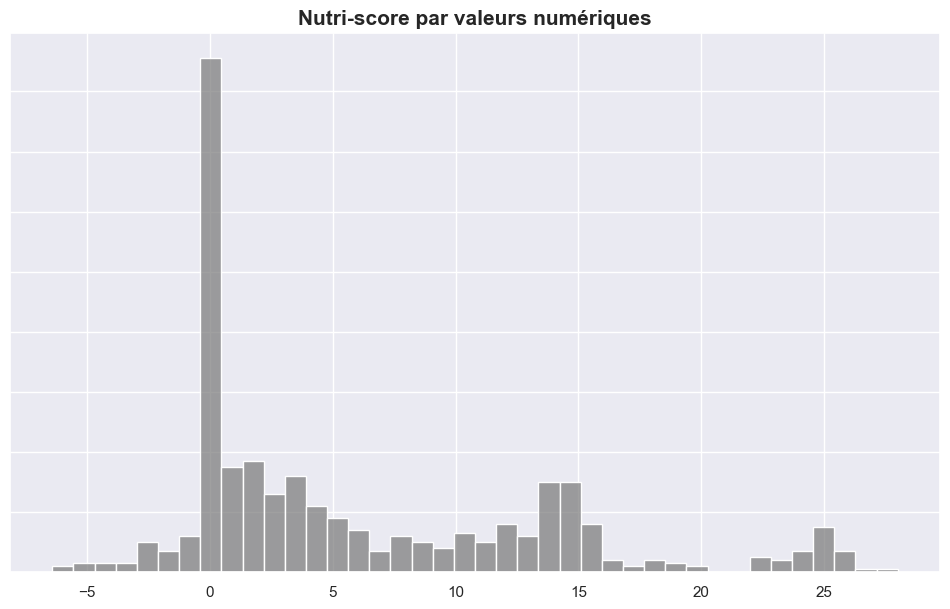

In [158]:
# Configuration de la taille de la figure
plt.figure(figsize=(12, 7))

# Création de l'histogramme avec histplot
h = sns.histplot(df_ns2_test["nutrition-score-fr_100g"], bins=40, color='grey', kde=False)

# Configuration du titre et des axes
h.set_title("Nutri-score par valeurs numériques", fontweight='bold', fontsize=15)
h.set_xlabel('') 
h.set_ylabel('')
h.set(yticklabels=[])
plt.show()

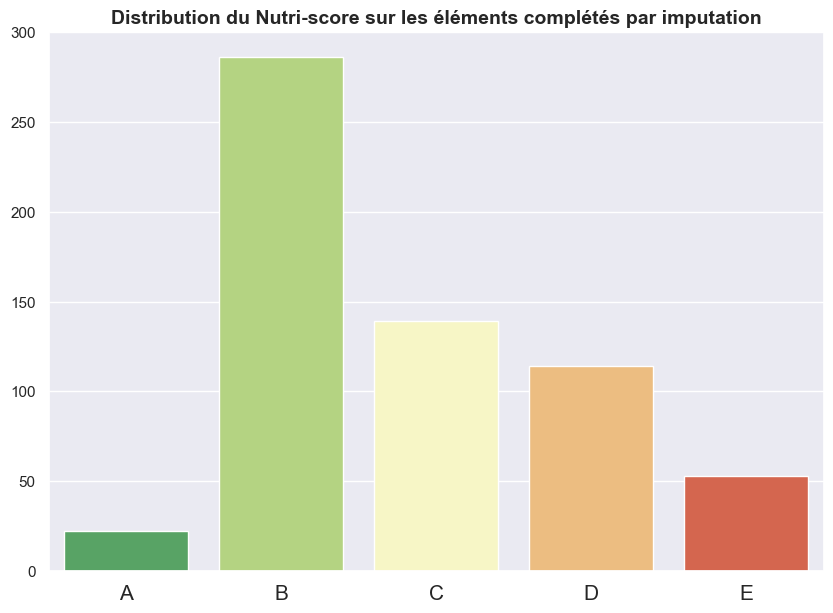

In [159]:
plt.figure(figsize=(10,7))
g = sns.countplot(x=df_ns2_test["nutrition_grade_fr"])
g.set_ylabel('') ; g.set_xlabel('')
g.tick_params(axis='x', which='major', labelsize=15)
g.set_title('Distribution du Nutri-score sur les éléments complétés par imputation', fontsize=14, fontweight='bold')
plt.show(g)

### Répartition des classes Nutri-score par macro-nutriment

In [160]:
pivot = pd.pivot_table(df_ns2_test, index = ['nutrition_grade_fr'], aggfunc=np.mean )

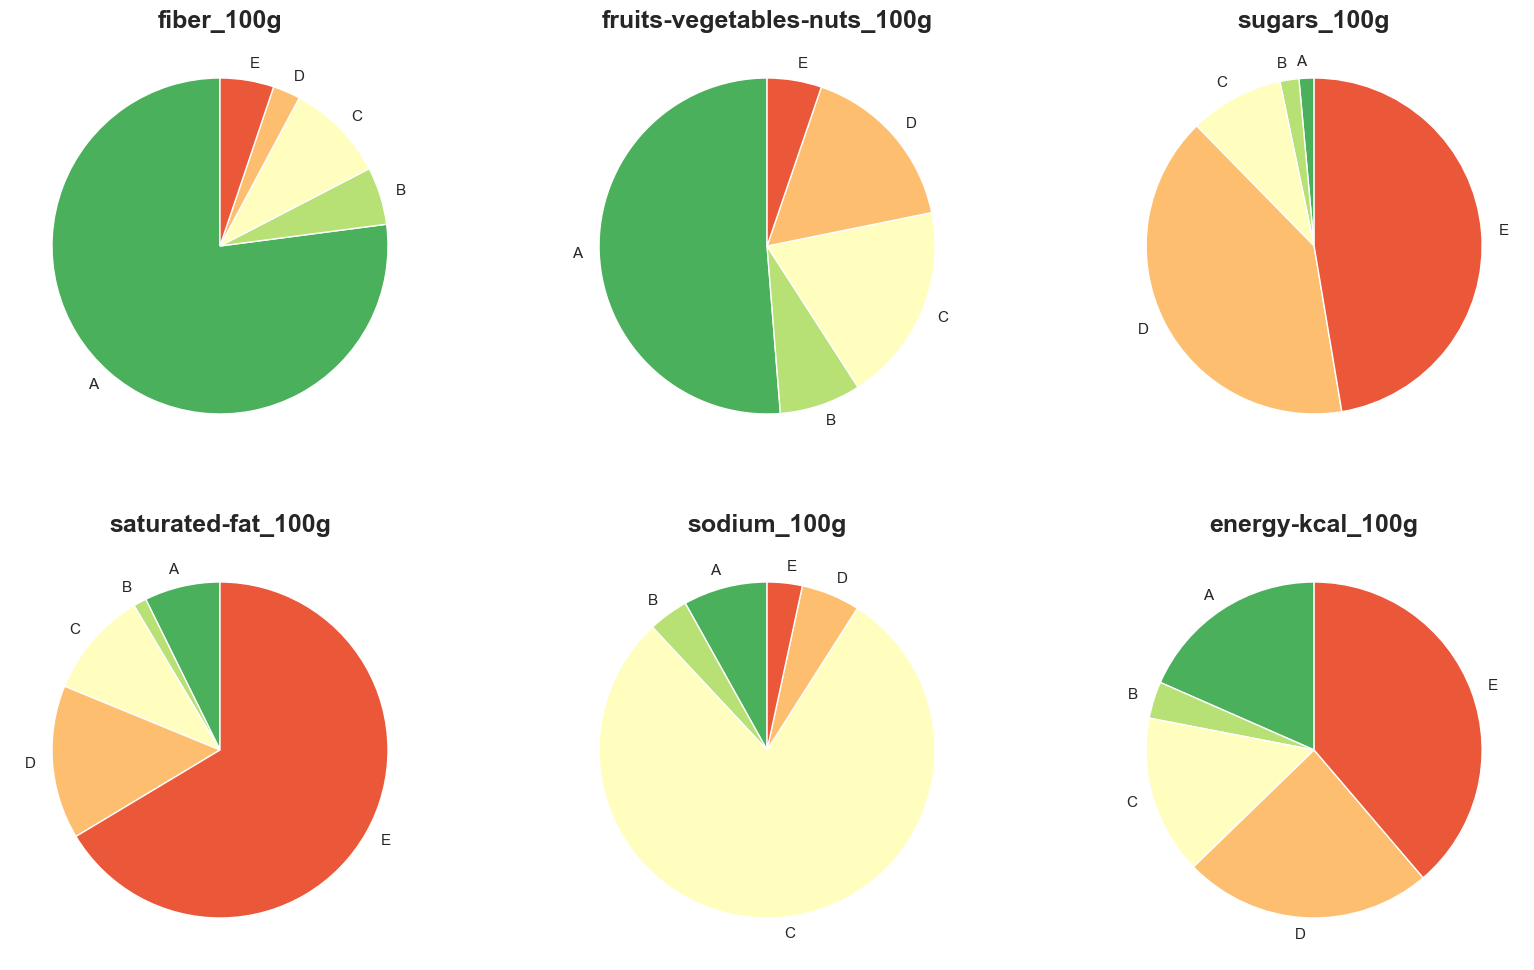

In [161]:
ns_items = data_dict['NS_ITEMS']
fig, ax = plt.subplots(2,3, figsize=(20,12))
ax = ax.flatten()

for i,cat in enumerate(ns_items):   
    pivot.plot.pie(ax=ax[i], y = cat, startangle=90) #, figsize=(16, 16))    
    ax[i].set_ylabel('')
    ax[i].set_title(cat, fontweight='bold', fontsize=18)
    ax[i].get_legend().remove()

## Analyses univariées - macro-nutriments, énergie

In [162]:
sns.set_style("darkgrid")
sns.set_context("talk")

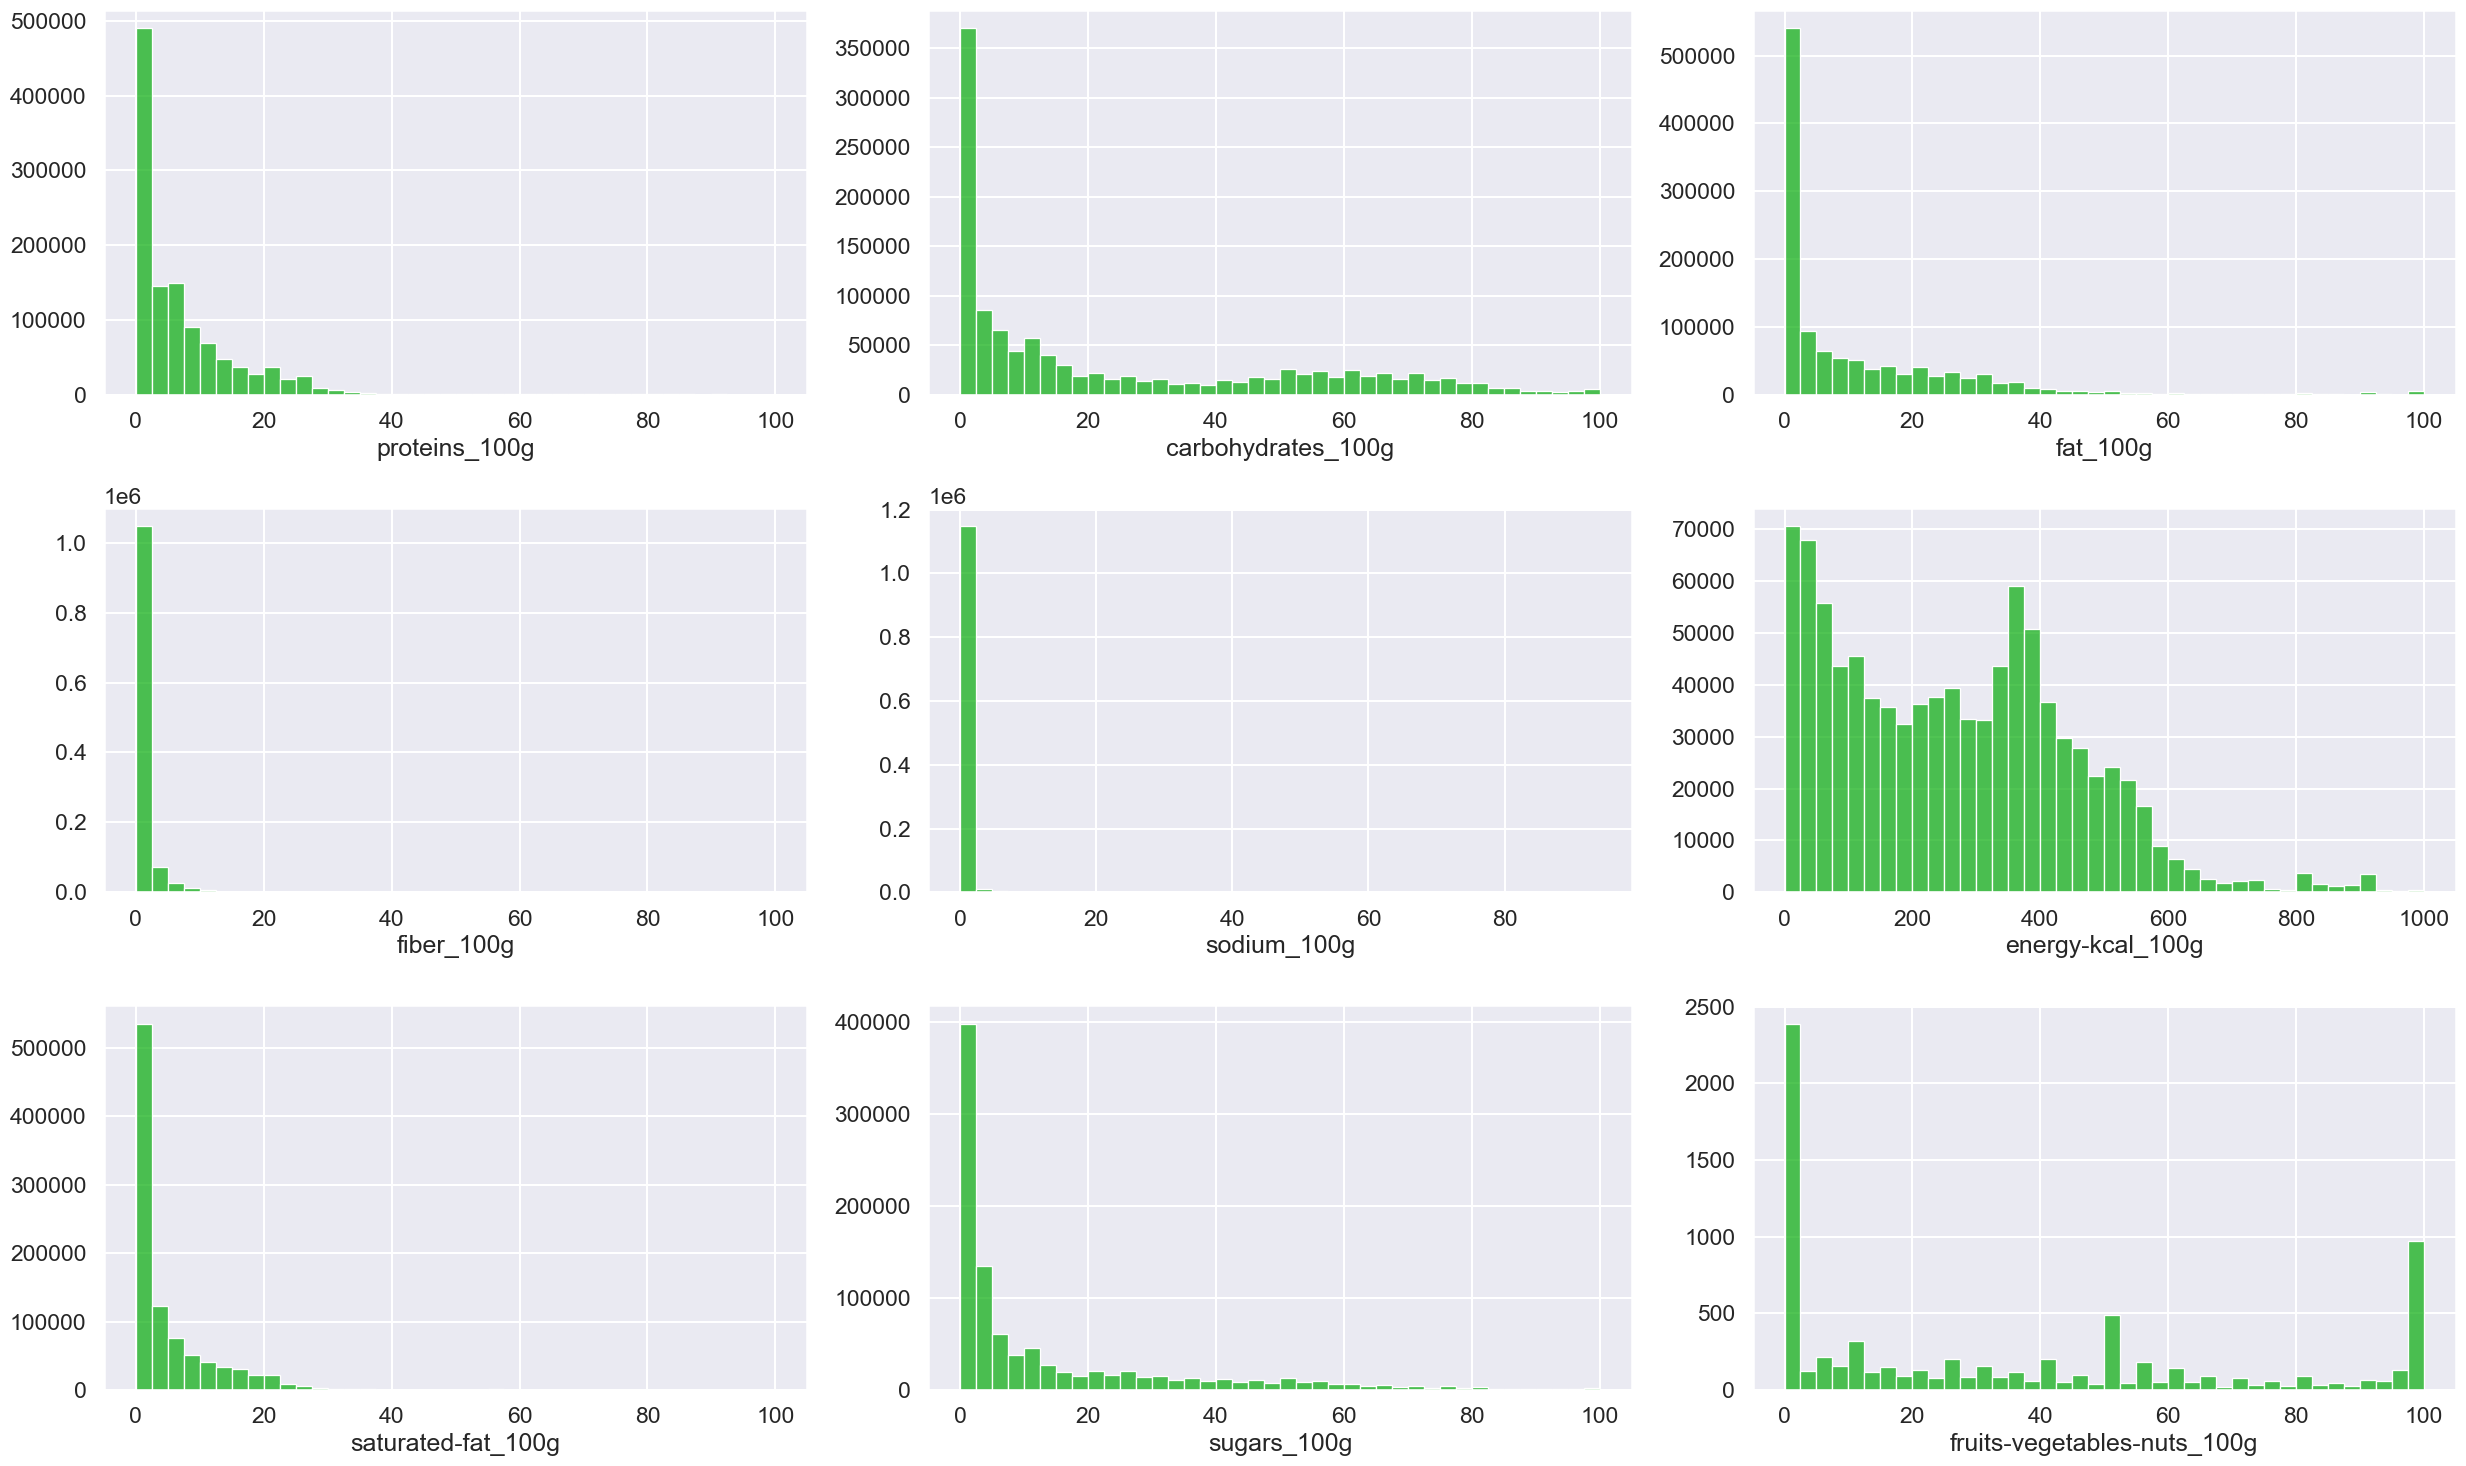

In [163]:
# Supposons que data_dict['MACRO NUTRIMENTS'] contienne la liste des nutriments
df_mn = data_dict['MACRO NUTRIMENTS'] + \
         ['energy-kcal_100g', 'saturated-fat_100g', 'sugars_100g', 'fruits-vegetables-nuts_100g']

# Création d'une figure avec des sous-graphiques
f, ax = plt.subplots(3, 3, figsize=(25, 15))
ax = ax.flatten()

# Boucle pour tracer les histogrammes
for i, macro_n in enumerate(df_mn):
    g = sns.histplot(df[macro_n], bins=40, kde=False, ax=ax[i], color="xkcd:green")
    g.set_ylabel('')

# Supprime le dernier graphique vide, en cas de nombre impair
# n = len(df_mn)
# if n % 2 != 0:
#     f.delaxes(ax[n])  # Utiliser n pour supprimer le dernier axe vide

# Ajustement de la mise en page
f.tight_layout() 
plt.show()

## Analyses par catégories

### 1ère visualisation : 'brut' (avec outliers)

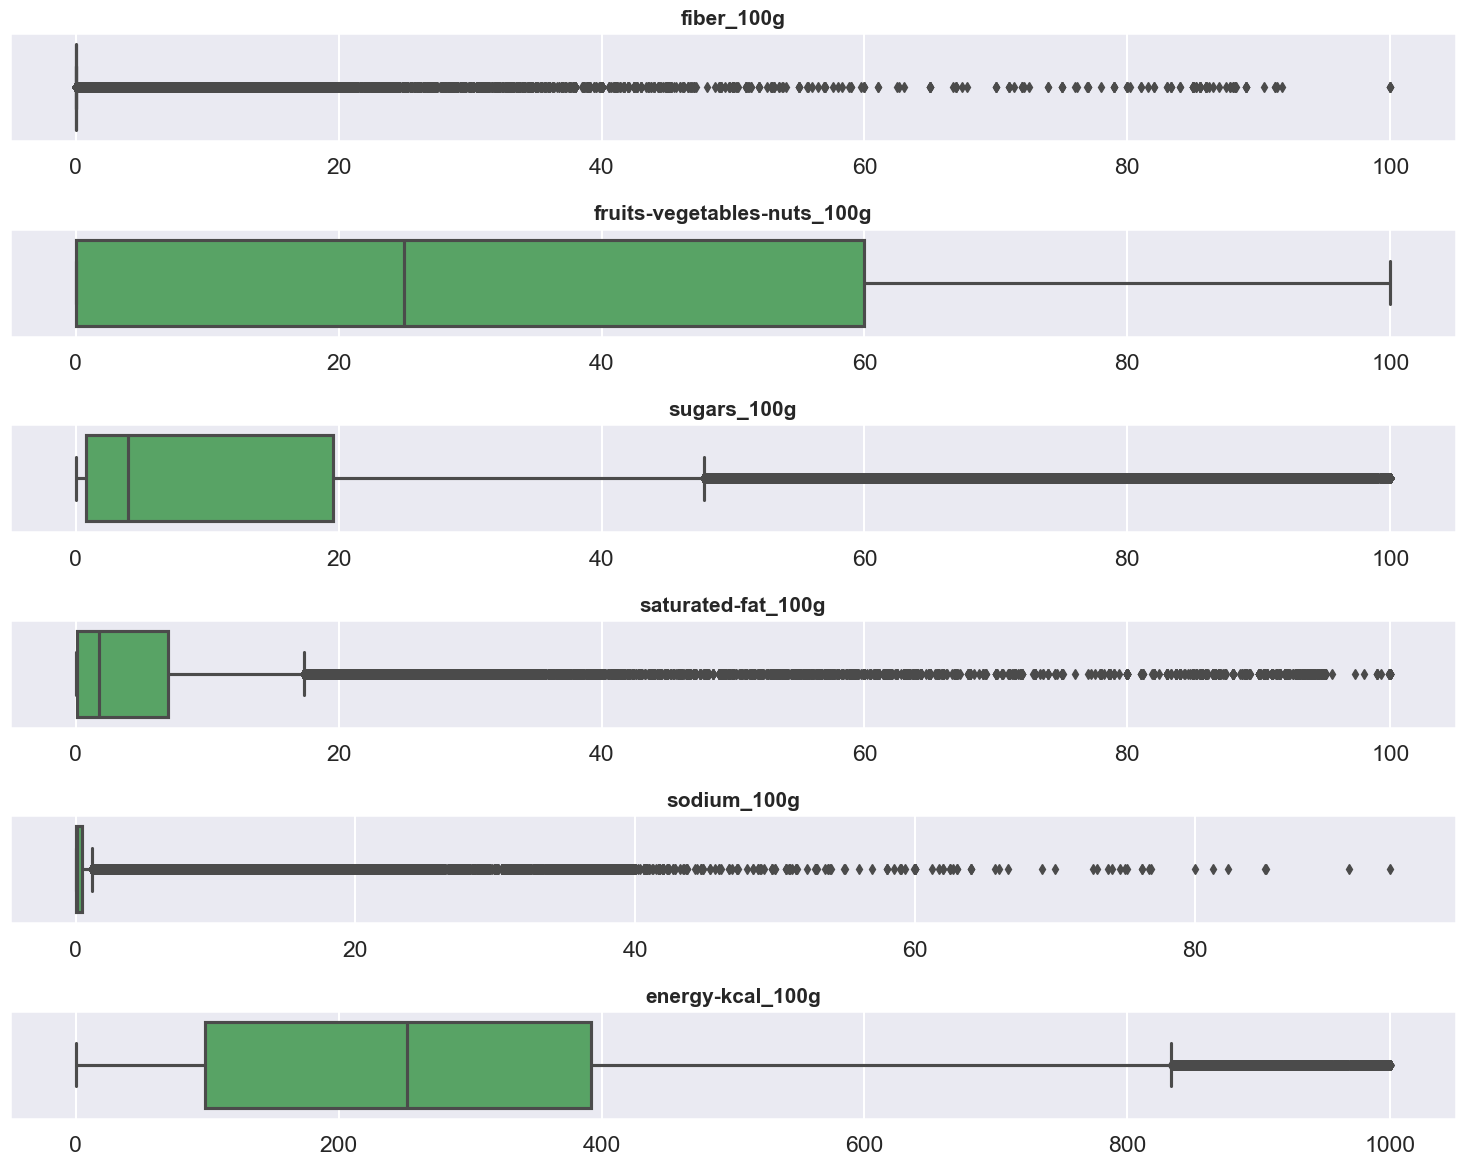

In [164]:
fig, ax = plt.subplots(len(ns_items), figsize=(15,12))
for i, macro_n in enumerate(ns_items):
    g = sns.boxplot(x=macro_n, data=df_ns, ax = ax[i]) #y="nutrition_grade_fr"
    g.set_xlabel('')
    g.set_title(macro_n, fontweight='bold', fontsize=15) 

fig.tight_layout()


### 2ème visualisation : filtrée (moins d'outliers extrêmes)

In [165]:
dict_nutriment_seuil = {"sugars_100g":90,
               "saturated-fat_100g":60,
               "sodium_100g":3,
               "fiber_100g":20,
               "fruits-vegetables-nuts_100g":101}

In [166]:
# filtrage des outliers à partir des seuils
df_ns_filtre = df_ns
for item, seuil in dict_nutriment_seuil.items():
    index_to_delete = df_ns_filtre.query("`{0}` > @seuil".format(item)).index
    df_ns_filtre = df_ns_filtre.drop(index = index_to_delete, axis=0)

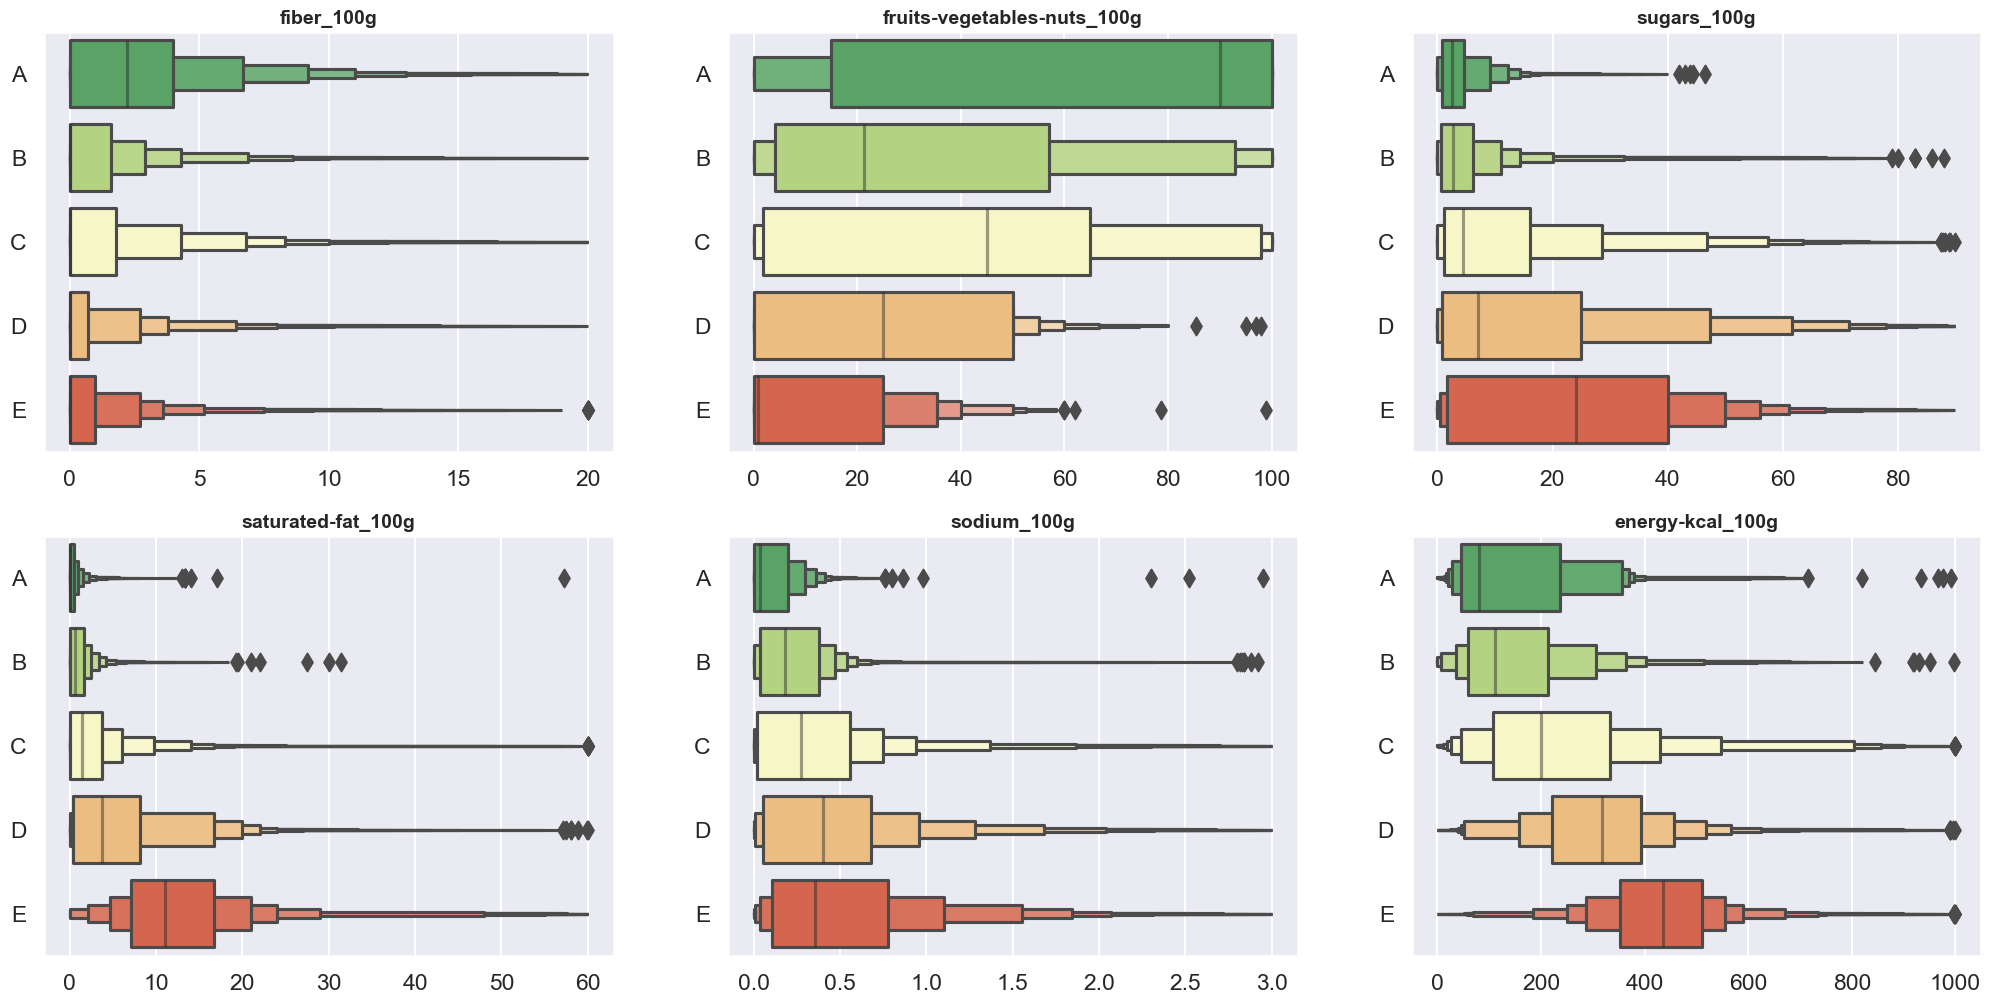

In [167]:
# for i, macro_n in enumerate(ns_items):
#     g = sns.catplot(x=macro_n, y="nutrition_grade_fr", data=df_ns_filtre, kind="boxen", aspect=1.5)


fig, ax = plt.subplots(2,3, figsize=(25,12))
ax = ax.flatten()
for i, macro_n in enumerate(ns_items):
    g = sns.boxenplot(x=macro_n, y="nutrition_grade_fr", data=df_ns_filtre, ax=ax[i])
    g.set_ylabel('') ; g.set_xlabel('')    
    g.set_title(macro_n, fontsize=14, fontweight='bold')

## Analyses bivariées

In [168]:
sns.set_context("talk")

In [169]:
#sélection du DF avec fruits-vegetables-nuts_100g renseigné
df_bivarie = df.dropna(subset=["fruits-vegetables-nuts_100g"])

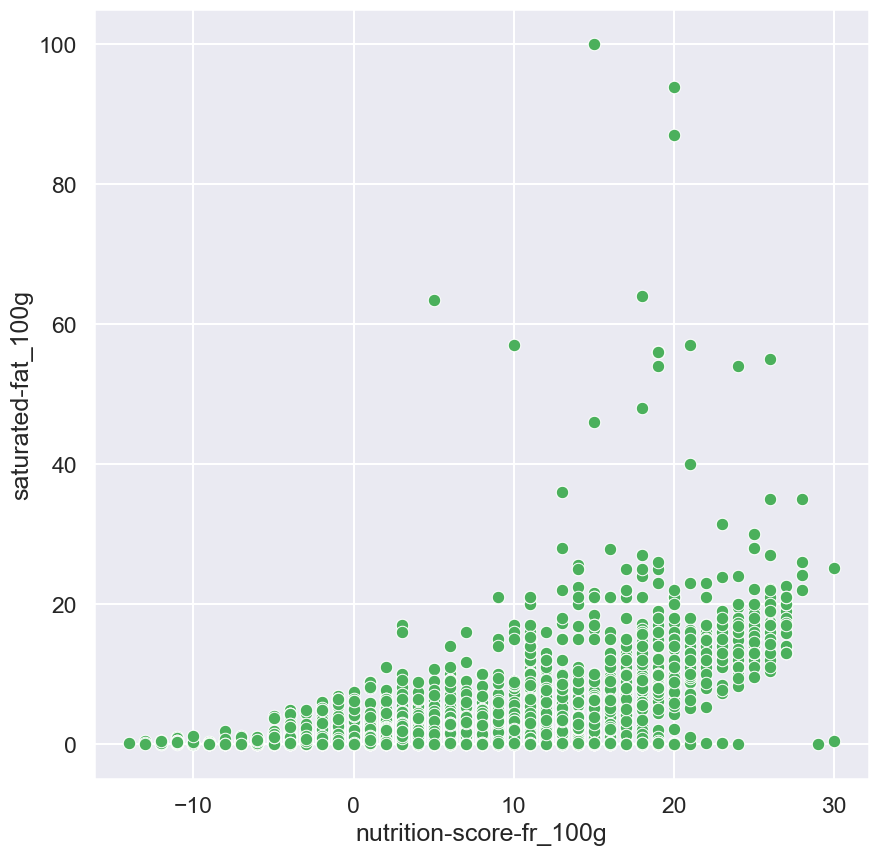

In [170]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="nutrition-score-fr_100g", y="saturated-fat_100g", data=df_bivarie)


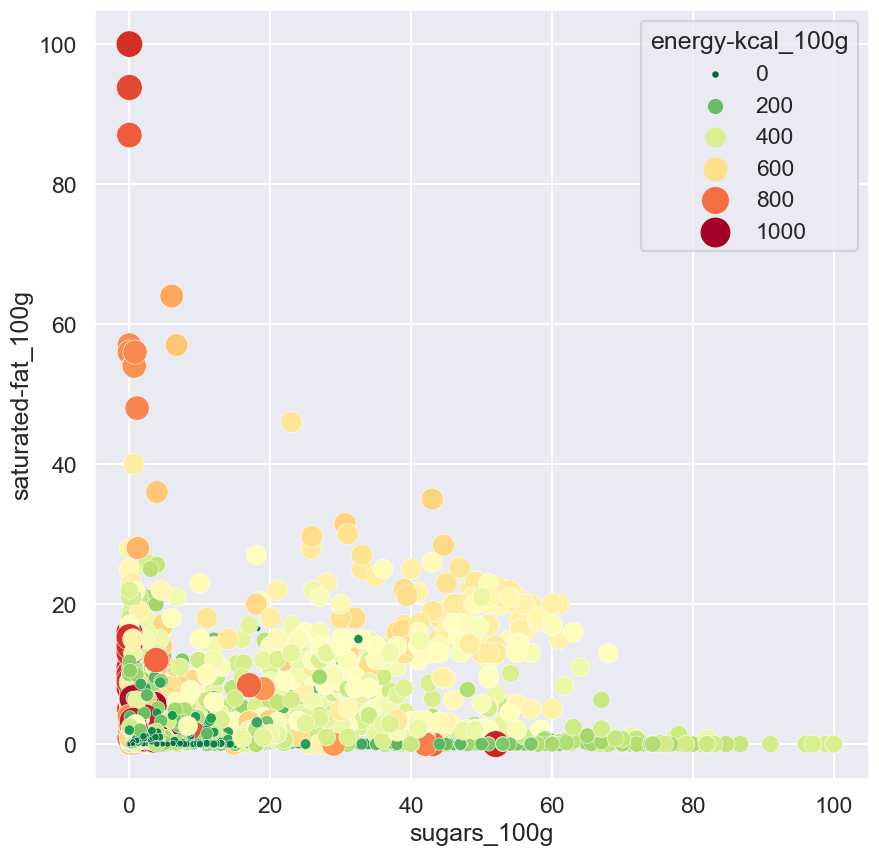

In [171]:
# norm_sizes = (df_bivarie["energy-kcal_100g"] - df_bivarie["energy-kcal_100g"].min()) / \
#              (df_bivarie["energy-kcal_100g"].max() - df_bivarie["energy-kcal_100g"].min())

fig = plt.figure(figsize=(10, 10))
g = sns.scatterplot(
    x="sugars_100g", 
    y="saturated-fat_100g", 
    size="energy-kcal_100g", 
    hue="energy-kcal_100g",
    palette="RdYlGn_r", 
    sizes=(10, 400), 
    data=df_bivarie
)
plt.show()

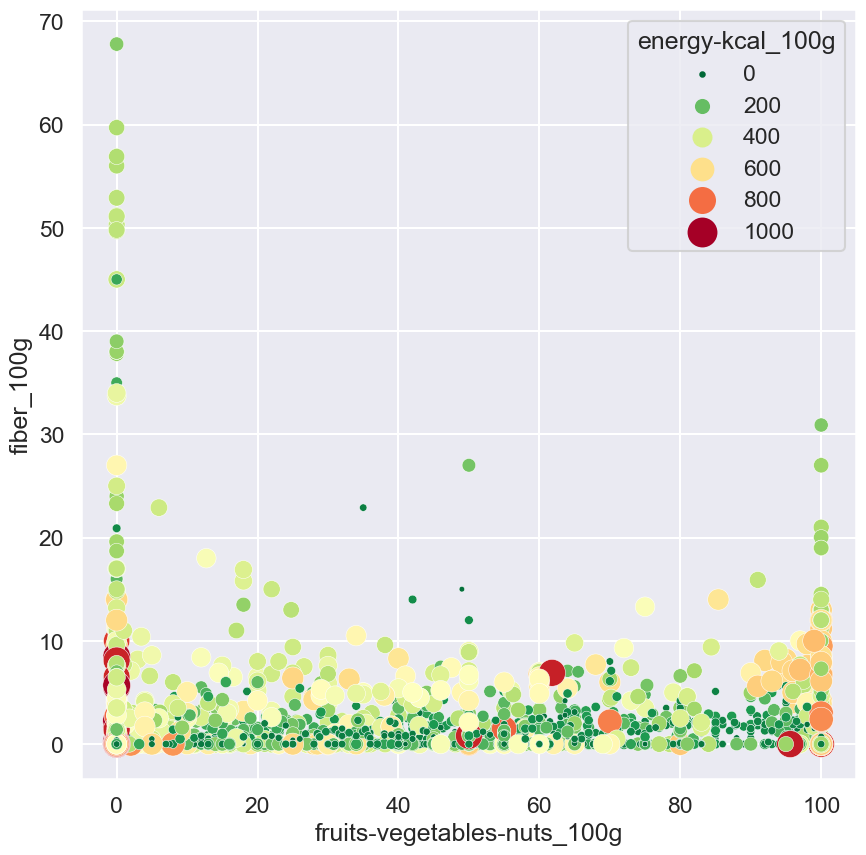

In [172]:
fig = plt.figure(figsize=(10, 10))
g = sns.scatterplot(
    x="fruits-vegetables-nuts_100g", 
    y="fiber_100g", 
    size="energy-kcal_100g", 
    hue="energy-kcal_100g",
    palette="RdYlGn_r", 
    sizes=(10, 400), 
    data=df_bivarie
)
plt.show()

## Analyses champs textuels

### Restriction aux produits français pour ce test

In [173]:
my_fields = set((data_dict['NS_BAD_ITEMS']
       +data_dict['NS_GOOD_ITEMS']
       +data_dict['NS_GRADE']
                 +data_dict['NAMES']
       +data_dict['MACRO NUTRIMENTS']
                 +data_dict['LABELS']
                 +['energy-kcal_100g']))

my_fields_list = list(my_fields)

In [174]:
df_fr = df.loc[df['labels_fr'].notna(), my_fields_list]
df_fr.shape

(294360, 16)

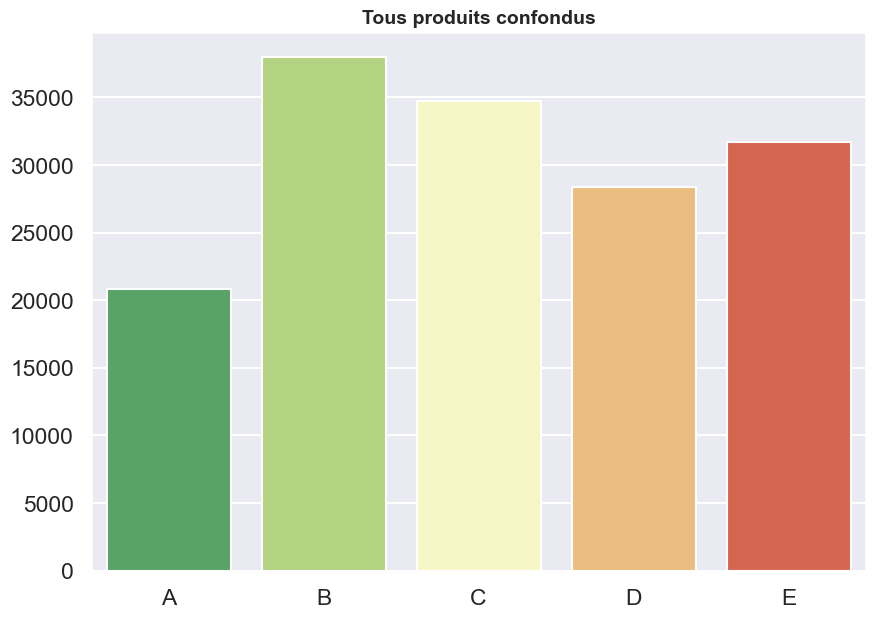

In [175]:
plt.figure(figsize=(10,7))
g = sns.countplot(x=df_fr["nutrition_grade_fr"], data=df_fr)
g.set_ylabel('') ; g.set_xlabel('') 
g.set_title('Tous produits confondus', fontsize=14, fontweight='bold')
plt.show(g)

#### Produits végétarien 

In [176]:
# Tests REGEX
s = "These are végétalien oranges and apples vegetalien and pears, but not pinapples or .."
r1 = re.compile(r'\bAND\b | \bOR\b | \bNOT\b', re.IGNORECASE | re.X)
r2 = re.compile(r'végétalien|vegetalien', re.IGNORECASE | re.X)
r2.findall(s)

['végétalien', 'vegetalien']

In [177]:
vg1_regex = re.compile(r'végétarien|vegetarien', re.IGNORECASE | re.X)
vg2_regex = re.compile(r'végétalien|vegetalien|vegan|veggie', re.IGNORECASE | re.X)

df_fr_vg = df_fr[ df_fr['labels_fr'].str.contains(vg2_regex, regex=True) ]

In [178]:
df_fr_vg.shape

(23415, 16)

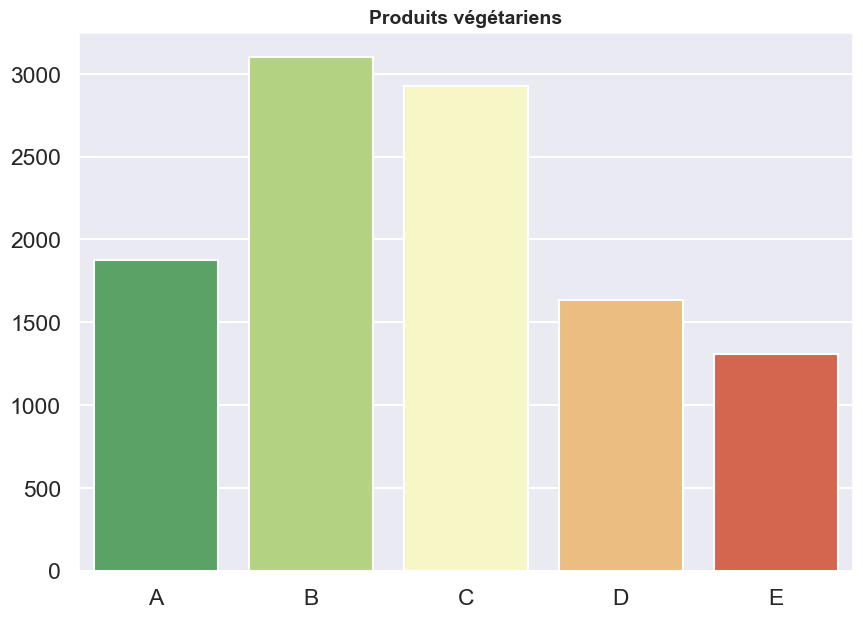

In [179]:
plt.figure(figsize=(10,7))
# sns.set(style="whitegrid")
g = sns.countplot(x=df_fr_vg["nutrition_grade_fr"], data=df_fr_vg)
g.set_ylabel('') ; g.set_xlabel('')
g.set_title('Produits végétariens', fontsize=14, fontweight='bold')
plt.show(g)

## Prototype application : recherche d'un 'équivalent' végé à un produit
Avec recherche de plus proches voisins

In [180]:
my_fields = set((data_dict['MACRO NUTRIMENTS']             
                 +['energy-kcal_100g']))
my_fields_list = list(my_fields)

In [181]:
# On prend tout simplement le DF complémentaire de df_fr_vg
df_fr_novg = df_fr.drop(df_fr_vg.index, axis=0)

In [182]:
# supprime les éléments avec NaN pour chaque df
df_fr_novg = df_fr_novg.dropna(axis=0, subset=my_fields, how="any")
df_fr_vg = df_fr_vg.dropna(axis=0, subset=my_fields, how="any")

In [183]:
df_fr_novg.shape

(208407, 16)

In [184]:
# on ne retient que les colonnes nécessaires à l'algo NearestNeighbors
df_fr_novg_nn = df_fr_novg[my_fields_list]
df_fr_vg_nn = df_fr_vg[my_fields_list]

In [185]:
n_neigh = NearestNeighbors(n_neighbors=5)
n_neigh.fit(df_fr_vg_nn)

NearestNeighbors()

In [186]:
columnsTitles = ['product_name','labels_fr','energy-kcal_100g','saturated-fat_100g']+data_dict['MACRO NUTRIMENTS']

In [187]:
df_fr_novg[df_fr_novg['product_name'] == 'Merguez véritables']

,fiber_100g,labels,energy-kcal_100g,saturated-fat_100g,labels_fr,sugars_100g,fat_100g,generic_name,fruits-vegetables-nuts_100g,product_name,proteins_100g,sodium_100g,carbohydrates_100g,labels_tags,nutrition_grade_fr,nutrition-score-fr_100g
1131,0.0,en:fr-bio-01,261.0,9.9,"Bio,Bio européen,FR-BIO-01",1.3,21.4,NaN,NaN,Merguez véritables,13.9,0.816,3.3,"en:organic,en:eu-organic,en:fr-bio-01",NaN,NaN
755474,0.0,"French meat, Made in France, fr:Viande Bovine ...",287.0,11.0,"Viande Française,Fabriqué en France,Sans conse...",0.5,25.0,NaN,NaN,Merguez véritables,15.0,0.720,0.5,"en:french-meat,en:made-in-france,en:no-preserv...",NaN,NaN


In [188]:
df_fr_novg[columnsTitles].loc[[1131]]

,product_name,labels_fr,energy-kcal_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,fat_100g,fiber_100g,sodium_100g
1131,Merguez véritables,"Bio,Bio européen,FR-BIO-01",261.0,9.9,13.9,3.3,21.4,0.0,0.816


In [189]:
# Exemple de recherche de voisins d'un élément carné : Merguez véritables
distances, index = n_neigh.kneighbors(df_fr_novg_nn.loc[[1131]])

In [190]:
df_fr_vg[columnsTitles].iloc[index[0]]

,product_name,labels_fr,energy-kcal_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,fat_100g,fiber_100g,sodium_100g
899607,Tofu fumé au sésame,"Végétarien,Sans gluten,Végétalien",259.0,3.9,13.6,3.2,21.4,0.0,0.80
864508,Tofu-Vienesas,"Bio,Végétarien,Bio européen,Végétalien,AB Agri...",264.0,2.6,15.0,5.4,20.0,0.0,0.72
1290878,Bio pomazànka s rajcaty a olivami,"Bio,Végétarien,Bio européen,Végétalien,en:AT-B...",260.0,2.6,10.0,5.5,21.0,0.0,0.60
734144,From'James,"Bio,Bio européen,Végétarien,Sans gluten,Végéta...",258.0,3.1,17.0,0.6,20.0,0.0,0.48
864519,Tofu Crisper,"Bio,Végétarien,Bio européen,Végétalien,en:DE-Ö...",256.0,2.5,13.0,2.2,19.0,0.0,0.60


### Complement : Méthode ACP 

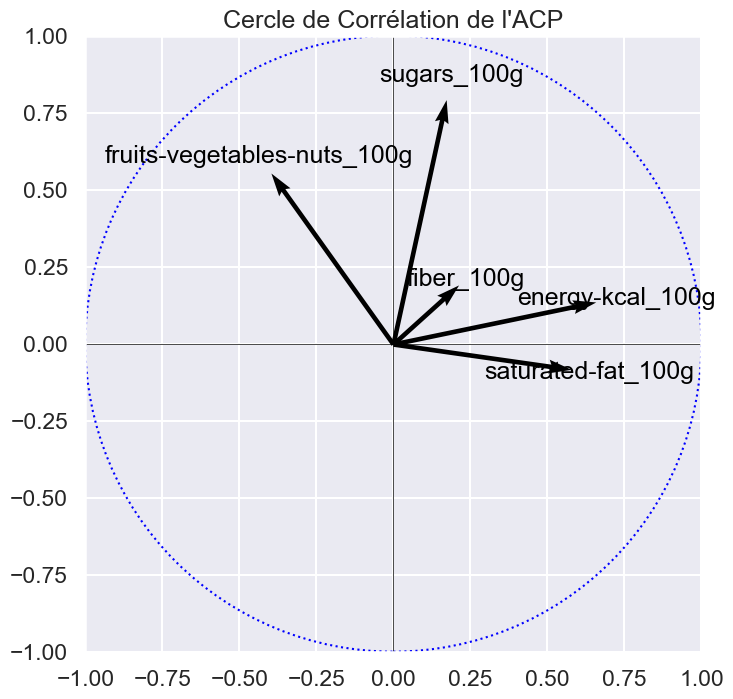

In [204]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


col = ['fiber_100g', 'energy-kcal_100g', 'saturated-fat_100g', 'sugars_100g', 'fruits-vegetables-nuts_100g', 'nutrition_grade_fr']
df_acp = df[col].dropna()

# Sélection des colonnes d'intérêt
columns = ["fiber_100g", 'energy-kcal_100g', 'saturated-fat_100g', 'sugars_100g', 'fruits-vegetables-nuts_100g']
df_selected = df_acp[columns]

# Normalisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Calcul de l'ACP
pca = PCA()
pca.fit(df_scaled)

# Récupération des composantes principales
components = pca.components_

# Créer un graphique des cercles de corrélation
plt.figure(figsize=(8, 8))

for i in range(components.shape[1]):
    plt.quiver(0, 0, components[0, i], components[1, i], angles='xy', scale_units='xy', scale=1, label=columns[i])

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='dotted')
plt.gca().add_artist(circle)
for i, col in enumerate(columns):
    plt.text(components[0, i]*1.1, components[1, i]*1.1, col, color='black', ha='center', va='center')


# graphique
plt.title("Cercle de Corrélation de l'ACP")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


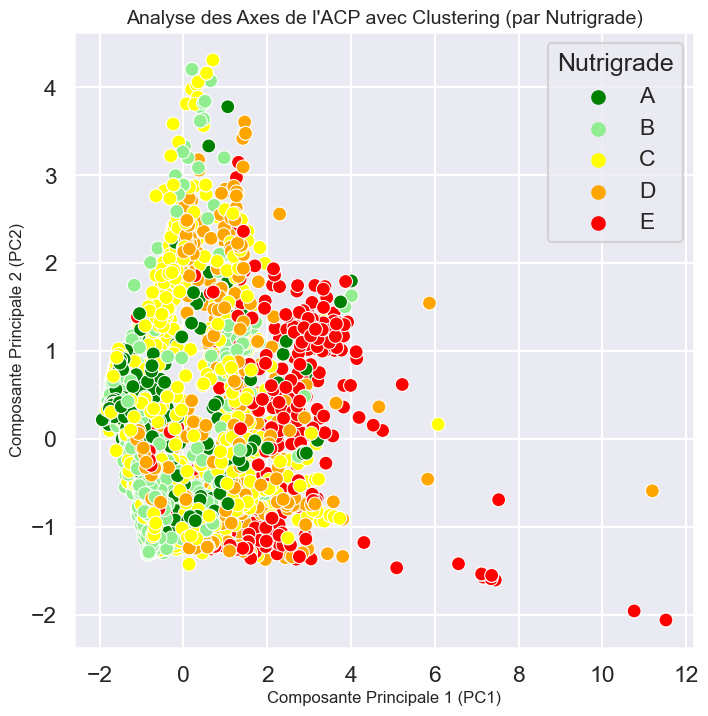

Variance expliquée par PC1: 0.36
Variance expliquée par PC2: 0.22
Composantes principales (charge des variables) :
     fiber_100g  energy-kcal_100g  saturated-fat_100g  sugars_100g  \
PC1    0.212851          0.658215            0.578413     0.172556   
PC2    0.191797          0.136526           -0.082269     0.793514   

     fruits-vegetables-nuts_100g  
PC1                    -0.396371  
PC2                     0.555105  


In [212]:
# Sélection des colonnes d'intérêt
df_selected = df_acp[columns]

# Normalisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Calcul de l'ACP
pca = PCA(n_components=2)  
principal_components = pca.fit_transform(df_scaled)

# Ajouter les composantes principales au DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Ajouter la colonne 'nutrigrade_fr' pour la clustering
df_pca['nutrition_grade_fr'] = df_acp['nutrition_grade_fr'].values

# Visualisation des clusters dans l'espace des 2 premières composantes principales
plt.figure(figsize=(8, 8))

color_map = {
    'A': 'green',        
    'B': 'lightgreen',   
    'C': 'yellow',     
    'D': 'orange',     
    'E': 'red'          
}

# Tracer les points colorés par le cluster
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='nutrition_grade_fr', palette=color_map, s=100, marker='o')

# Ajouter des labels aux axes
plt.title("Analyse des Axes de l'ACP avec Clustering (par Nutrigrade)", fontsize=14)
plt.xlabel("Composante Principale 1 (PC1)", fontsize=12)
plt.ylabel("Composante Principale 2 (PC2)", fontsize=12)

# Ajouter une légende
plt.legend(title="Nutrigrade", loc='upper right')

# Afficher le graphique
plt.grid(True)
plt.show()

# Affichage de la variance expliquée par les 2 premières composantes principales
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1: {explained_variance[0]:.2f}")
print(f"Variance expliquée par PC2: {explained_variance[1]:.2f}")

# Analyse de la corrélation des variables avec les composantes principales
print("Composantes principales (charge des variables) :")
print(pd.DataFrame(pca.components_, columns=columns, index=["PC1", "PC2"]))
